##Importing all csv files using a MultiIndex structure

Samplingpoint -> Pollutant -> StartTime

Rows containing Bulk in the Samplingpoint name are dropped, because they are only monthly

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import math
import os
import glob
%matplotlib inline

package_dir = os.getcwd()

print(package_dir)

df = pd.DataFrame()

print('Loading CSVs\n')
for file in glob.glob('res/*.csv'):
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4, 8, 13])
    df = pd.concat([df, read])
print('\nFinished Loading')
print('Sorting')
df = df.sort_index()
print('Finished sorting')

/home/sebastian/Programming/Bachelorthesis
Loading CSVs




Finished Loading
Sorting


Finished sorting


In [42]:
print(df.dtypes)
print(df.head())

Countrycode                  object
Namespace                    object
AirQualityNetwork            object
AirQualityStation            object
SamplingPoint                object
SamplingProcess              object
Sample                       object
AirPollutantCode             object
AveragingTime                object
Concentration               float64
UnitOfMeasurement            object
DatetimeEnd          datetime64[ns]
Validity                      int64
Verification                  int64
dtype: object
                                                          Countrycode  \
AirQualityStationEoICode AirPollutant DatetimeBegin                     
DESN025                  As in PM10   2012-12-31 23:00:00          DE   
                                      2013-01-06 23:00:00          DE   
                                      2013-01-12 23:00:00          DE   
                                      2013-01-18 23:00:00          DE   
                                      2013-0

Multiindex can be navigated using the loc method.

Row selection is done via the [] operator using counting slices or datetime parsed from strings

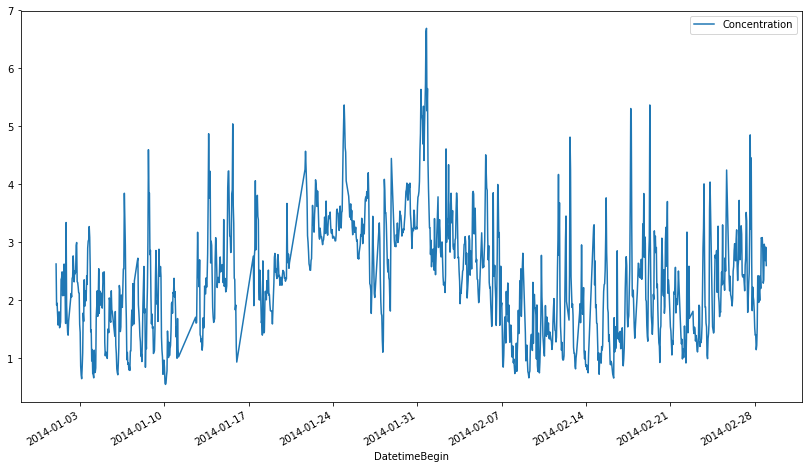

In [55]:
df.loc['DESN025', 'C6H6']['2014-01':'2014-02'].plot(y='Concentration', figsize=(14,8))

In [5]:
for eoi, new_df in df.groupby(level=0):
    print(new_df.groupby(['AirPollutant']).count()['AirPollutantCode'], '\n')

AirPollutant
As in PM10                         243
BaP in PM10                        485
Benzo(a)anthracene in PM10         485
Benzo(b)fluoranthene in PM10       485
Benzo(j)fluoranthene in PM10       485
Benzo(k)fluoranthene in PM10       485
C6H5-CH3                         31400
C6H6                             41804
Cd                                  48
Cd in PM10                         243
Dibenzo(ah)anthracene in PM10      485
EC in PM10                         182
Indeno-(1,2,3-cd)pyrene in PM      485
NO                               46093
NO2                              37399
NOX as NO2                       44090
Ni in PM10                         233
OC in PM10                         182
PM10                             47831
PM2.5                             1829
Pb                                  48
Pb in PM10                         243
SO2                              45799
Name: AirPollutantCode, dtype: int64 



AirPollutant
Cd               47
EC in PM10      181
NO            46210
NO2           37495
NOX as NO2    44242
O3            46161
OC in PM10      181
PM10          47594
PM2.5          1830
Pb               47
Name: AirPollutantCode, dtype: int64 

AirPollutant
As in PM10                         243
BaP in PM10                        483
Benzo(a)anthracene in PM10         483
Benzo(b)fluoranthene in PM10       483
Benzo(j)fluoranthene in PM10       483
Benzo(k)fluoranthene in PM10       483
Cd in PM10                         243
Dibenzo(ah)anthracene in PM10      483
EC in PM10                         182
Indeno-(1,2,3-cd)pyrene in PM      483
NO                               46242
NO2                              37500
NOX as NO2                       44189
Ni in PM10                         233
OC in PM10                         182
PM10                             47473
Name: AirPollutantCode, dtype: int64 

AirPollutant
O3    46318
Name: AirPollutantCode, dtype: int64 



In [98]:
ds = pd.to_datetime(df.loc['DESN025', 'PM10'].index.values)
y = df.loc['DESN025', 'PM10', :]['Concentration'].values

print(ds)
print(y, '\n')

df2 = pd.DataFrame(data={'ds':ds, 'y':y})

print(df2.head())
print(df2.dtypes)

#print(df.loc['DESN025'].groupby(['AirPollutant']).count()['AirPollutantCode'])

DatetimeIndex(['2012-12-31 23:00:00', '2012-12-31 23:00:00',
               '2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               ...
               '2018-04-27 04:00:00', '2018-04-27 05:00:00',
               '2018-04-27 06:00:00', '2018-04-27 07:00:00',
               '2018-04-27 08:00:00', '2018-04-27 09:00:00',
               '2018-04-27 10:00:00', '2018-04-27 11:00:00',
               '2018-04-27 12:00:00', '2018-04-27 13:00:00'],
              dtype='datetime64[ns]', length=47831, freq=None)
[200.165  34.72  205.237 ...  14.69   17.26   13.37 ] 

                   ds        y
0 2012-12-31 23:00:00  200.165
1 2012-12-31 23:00:00   34.720
2 2013-01-01 00:00:00  205.237
3 2013-01-01 01:00:00   61.588
4 2013-01-01 02:00:00   27.727
ds    datetime64[ns]
y            float64
dtype: object


ds    47831
y     47831
dtype: int64


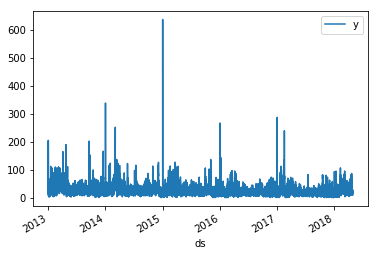

In [48]:
df2.plot(x='ds', y='y')
print(df2.count())

In [99]:
np.seterr(divide='ignore')
df2['y'] = pd.DataFrame(np.log(df2['y'])).replace([np.inf, -np.inf], 0)
np.seterr(divide='warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

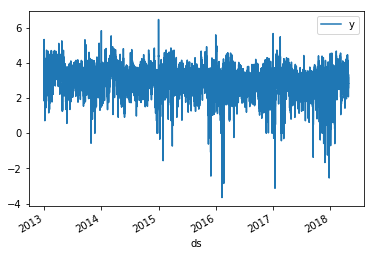

In [100]:
df2.plot(x='ds', y='y')

In [153]:
df2_train = df2[:20000]
df2_test = df2[20000:20240]

In [154]:
model = Prophet()

In [155]:
model.fit(df2_train)
future = model.make_future_dataframe(periods=240, freq='H')

/usr/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [157]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
20235,2015-04-03 03:00:00,3.355532,2.722443,4.000336
20236,2015-04-03 04:00:00,3.423485,2.773418,4.011395
20237,2015-04-03 05:00:00,3.516400,2.829119,4.186509
20238,2015-04-03 06:00:00,3.597298,2.908841,4.266516
20239,2015-04-03 07:00:00,3.641075,3.008945,4.287153


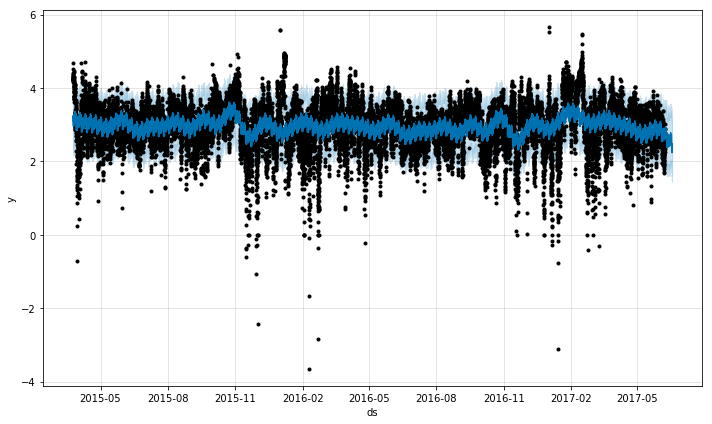

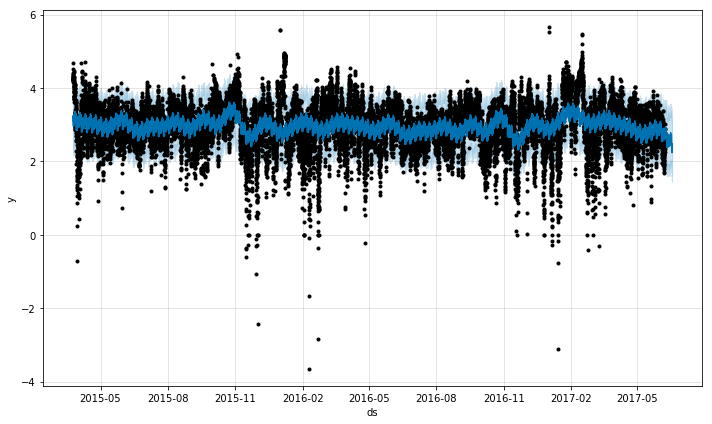

In [131]:
model.plot(forecast)


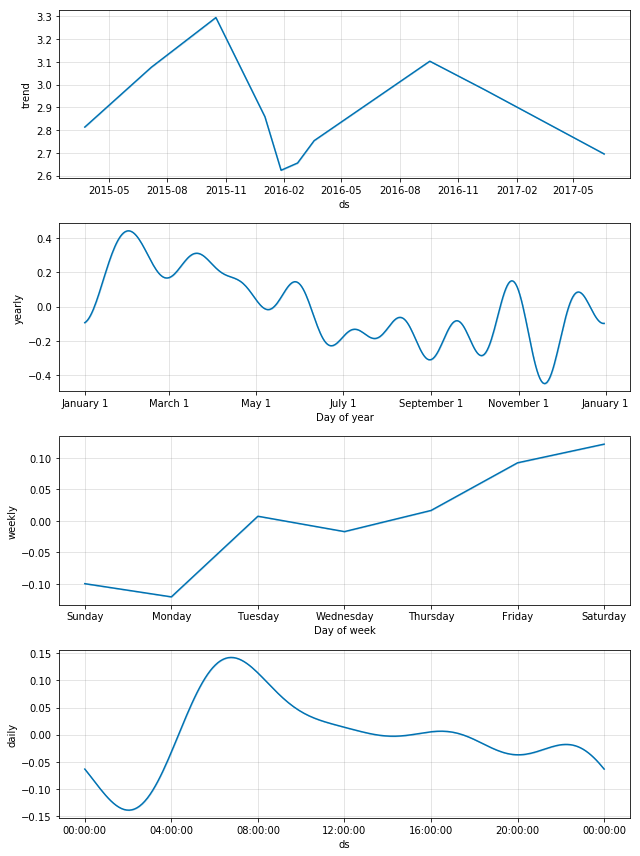

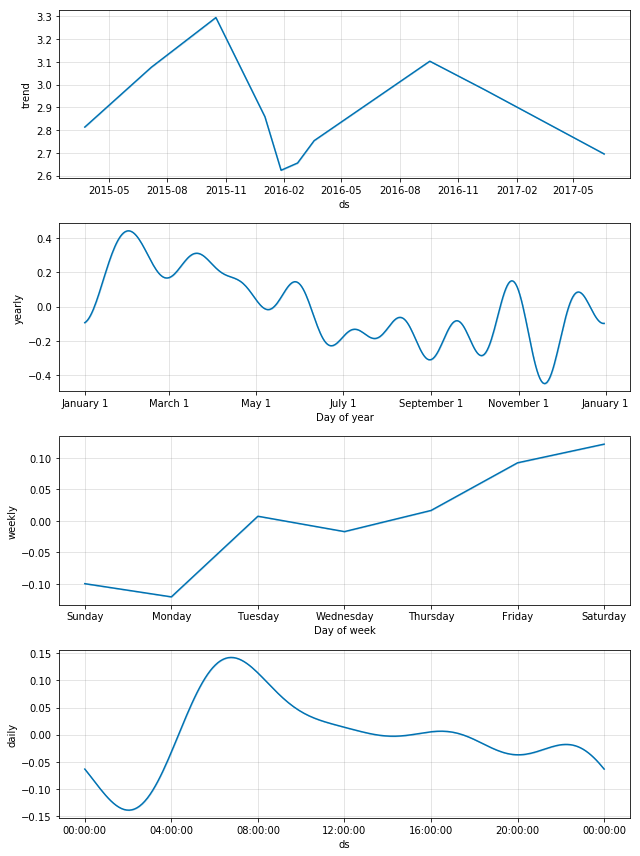

In [132]:
model.plot_components(forecast)

In [158]:
# retransform using e
y_hat = np.exp(forecast['yhat'][20000:])
y_true = np.exp(df2_test['y'])
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 592.64 MSE (24.34 RMSE)


In [152]:
print(y_hat)

20000    16.258258
20001    16.006944
20002    15.859016
20003    15.731813
20004    15.670515
20005    15.736768
20006    15.868634
20007    15.896190
20008    15.723329
20009    15.469444
20010    15.369823
20011    15.524650
20012    15.745986
20013    15.673901
20014    15.145789
20015    14.449777
20016    14.124933
20017    14.571362
20018    15.816671
20019    17.426232
20020    18.648691
20021    18.956254
20022    18.487597
20023    17.792589
20024    17.279342
20025    17.005498
20026    16.834376
20027    16.677593
20028    16.582437
20029    16.613138
           ...    
20210    13.109110
20211    14.289535
20212    15.122879
20213    15.196827
20214    14.647662
20215    13.929019
20216    13.364210
20217    12.993267
20218    12.707374
20219    12.438804
20220    12.222994
20221    12.106081
20222    12.037804
20223    11.889800
20224    11.595334
20225    11.248246
20226    11.020361
20227    10.978507
20228    10.984906
20229    10.790761
20230    10.294187
20231     9.